In [109]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import acquire
import prepare

In [2]:
df = pd.read_csv('saas.csv')
df.columns = [col.lower() for col in df.columns]

In [3]:
df.index = pd.to_datetime(df.month_invoiced)
df = df.drop(columns=['month_invoiced'])

In [4]:
# split into train, validation, test
train = df.loc[:'2016-01-31']
validate = df.loc['2016-01-31':'2017-01-31']
test = df.loc['2017-01-31': ]

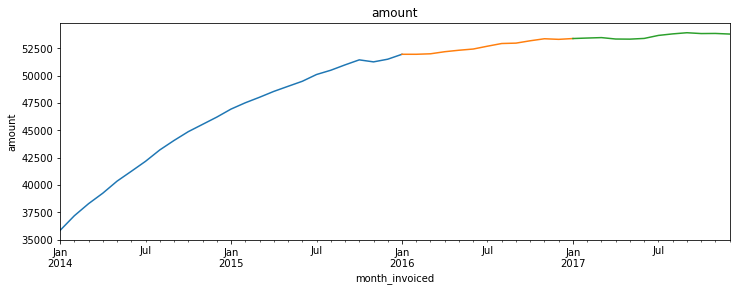

In [5]:
col = 'amount'
resample_by = 'M'
plt.figure(figsize=(12,4))
train.resample(resample_by).sum().amount.plot()
validate.resample(resample_by).sum().amount.plot()
test.resample(resample_by).sum().amount.plot()
plt.ylabel(col)
plt.title(col)
plt.show()


In [6]:
train = train.resample('M').sum()
validate = validate.resample('M').sum()
test = test.resample('M').sum()

In [7]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'Predicted')
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [8]:
amount = train.resample('M').amount.sum()[-1:][0]

yhat_df = pd.DataFrame({'amount': [amount]}, 
                       index = validate.index)

yhat_df.head(2)


,amount
month_invoiced,
2016-01-31,51955.0
2016-02-29,51955.0


amount -- RMSE: 897


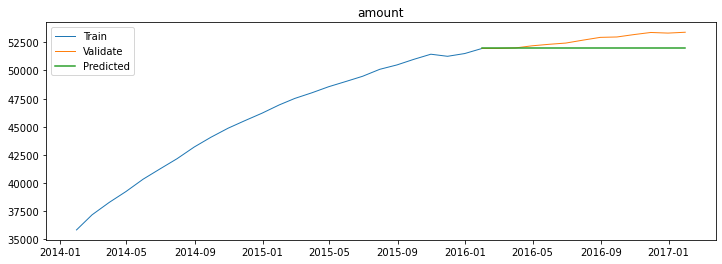

In [9]:
plot_and_eval('amount')

In [10]:
eval_df = append_eval_df(model_type='last_observed_value', target_var = 'amount')

In [11]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,897.0


Simple average

In [12]:
amount = train.resample('M').amount.sum().mean()

yhat_df = pd.DataFrame({'amount': [amount]}, 
                       index = validate.index)

yhat_df.head(2)

,amount
month_invoiced,
2016-01-31,45824.0
2016-02-29,45824.0


amount -- RMSE: 6870


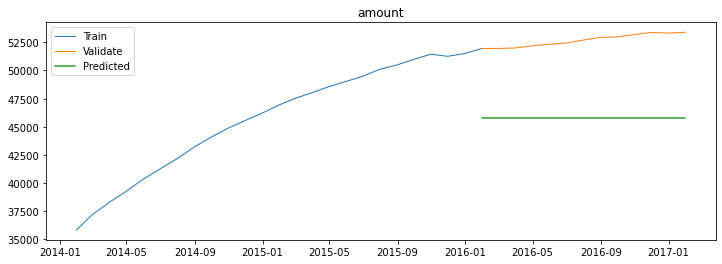

In [13]:
plot_and_eval('amount')

In [14]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [15]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,897.0
1,simple_average,amount,6870.0


In [16]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 10

amount = round(train.resample('M').amount.sum().rolling(period).mean().iloc[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'amount': [amount],
                           }, index = validate.index)
yhat_df.head(2)

,amount
month_invoiced,
2016-01-31,50482.0
2016-02-29,50482.0


amount -- RMSE: 2256


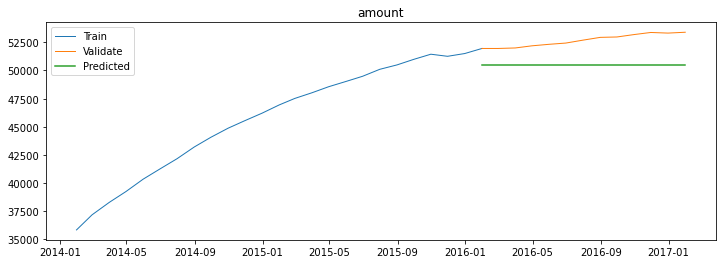

In [17]:
plot_and_eval('amount')

In [18]:
append_eval_df(model_type='10M moving average',target_var='amount')

,model_type,target_var,rmse
0,last_observed_value,amount,897.0
1,simple_average,amount,6870.0
2,10M moving average,amount,2256.0


In [19]:
periods = range(1,12)

for p in periods:
    

    amount = round(train.resample('M').amount.sum().rolling(p).mean().iloc[-1], 2)

    # yhat_df = make_predictions()

    yhat_df = pd.DataFrame({'amount': [amount],
                               }, index = validate.index)

    model_type = str(p) + 'M moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'amount'
                            )


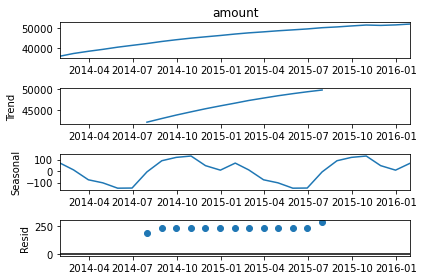

In [25]:
sm.tsa.seasonal_decompose(train.amount).plot()
None

In [26]:

model = Holt(train.amount, exponential = False)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['amount'] = round(yhat_items, 2)


amount -- RMSE: 7114


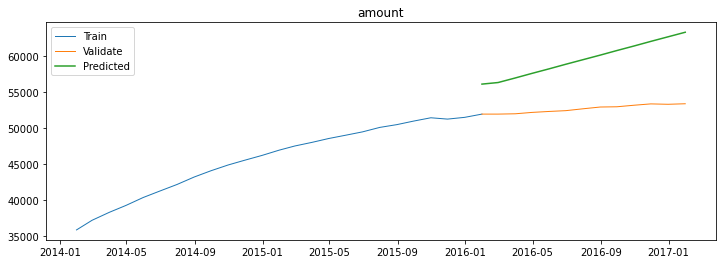

In [27]:
plot_and_eval('amount')

In [30]:
append_eval_df(model_type='Holts', target_var='amount')

,model_type,target_var,rmse
0,last_observed_value,amount,897.0
1,simple_average,amount,6870.0
2,1M moving average,amount,897.0
3,2M moving average,amount,1086.0
4,3M moving average,amount,1224.0
5,4M moving average,amount,1253.0
6,5M moving average,amount,1354.0
7,6M moving average,amount,1499.0
8,7M moving average,amount,1656.0
9,8M moving average,amount,1849.0


Use previous cycle

In [90]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [91]:
train = train.resample('M').sum()
validate = validate.resample('M').sum()
test = test.resample('M').sum()

In [92]:
yhat_df = train['2015'] + train.diff(12).mean()

In [93]:
yhat_df

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2015-01-31,1.610465e+10,8.715585e+10,11006.75,55033.75
2015-02-28,1.595642e+10,8.668951e+10,11121.75,55608.75
2015-03-31,1.580715e+10,8.621000e+10,11222.75,56113.75
2015-04-30,1.565336e+10,8.570140e+10,11329.75,56648.75
2015-05-31,1.550303e+10,8.520072e+10,11422.75,57113.75
2015-06-30,1.536759e+10,8.477223e+10,11514.75,57573.75
2015-07-31,1.523028e+10,8.432606e+10,11638.75,58193.75
2015-08-31,1.509680e+10,8.389434e+10,11716.75,58583.75
2015-09-30,1.495113e+10,8.339126e+10,11814.75,59073.75


In [94]:
pd.concat([yhat_df.head(1), validate.head(1)])

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2015-01-31,1.610465e+10,8.715585e+10,11006.75,55033.75
2016-01-31,1.635248e+10,8.781191e+10,10391.00,51955.00


In [95]:
yhat_df.index = validate.index

In [96]:
yhat_df = pd.DataFrame(yhat_df)

amount -- RMSE: 5192


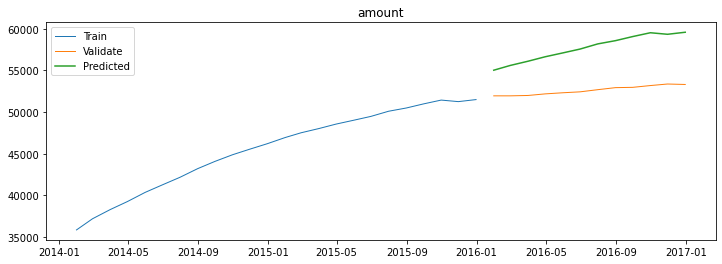

In [99]:
plot_and_eval('amount')
eval_df = append_eval_df(model_type='previous_year', target_var='amount')

In [103]:
# get the min rmse for each variable

min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_amount)
        )]


,model_type,target_var,rmse
0,last_observed_value,amount,897.0
2,1M moving average,amount,897.0


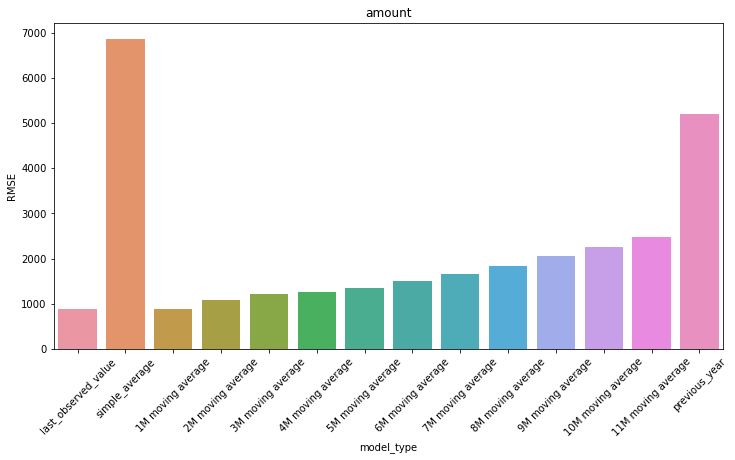

In [105]:
x = eval_df[eval_df.target_var == 'amount']['model_type']
y = eval_df[eval_df.target_var == 'amount']['rmse']
plt.figure(figsize=(12, 6))
sns.barplot(x, y)
plt.title(col)
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

In [107]:
df.resample('M').sum()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,20199990000,100199990000,7170.0,35850.0
2014-02-28,20000052061,99592010100,7438.0,37190.0
2014-03-31,19799172212,98967090801,7659.0,38295.0
2014-04-30,19613251862,98406535365,7851.0,39255.0
2014-05-31,19421255289,97804559262,8071.0,40355.0
2014-06-30,19238538842,97237565457,8251.0,41255.0
2014-07-31,19051670683,96639576096,8434.0,42170.0
2014-08-31,18873025377,96072248040,8642.0,43210.0
2014-09-30,18695106282,95500066207,8815.0,44075.0


In [111]:
store = acquire.acquire_all()
store = prepare.prepare_store(store)

In [116]:
store.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='sale_date', length=913000, freq=None)